# Práctica del módulo NLP

Importo los paquetes necesarios

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re
from collections import Counter

from spacy.lang.es.stop_words import STOP_WORDS

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

Cargo los datos y le asigno un topic a cada dataset

In [2]:
aiv5 = pd.read_csv("Amazon_Instant_Video_5.csv")  # Topic 1
a5 = pd.read_csv("Automotive_5.csv")              # Topic 2
dm5 = pd.read_csv("Digital_Music_5.csv")          # Topic 3
mi5 = pd.read_csv("Musical_Instruments_5.csv")    # Topic 4
plg5 = pd.read_csv("Patio_Lawn_and_Garden_5.csv") # Topic 5

In [3]:
aiv5["topic"] = 1
a5["topic"] = 2
dm5["topic"] = 3
mi5["topic"] = 4
plg5["topic"] = 5

Mezclo y remuevo todos mis datos

In [4]:
reviews = pd.concat([aiv5,a5,dm5,mi5,plg5], ignore_index=True).dropna(subset=['reviewText']).sample(frac=1)

In [5]:
reviews

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,topic
13964,A2U9LITOWKV5MI,B004VB5JDW,Abe C.,"[4, 5]",I have washed these towels several times and I...,1,Very linty,1371945600,"06 23, 2013",2
37047,A14Z9LAETO21KL,B000KIRT74,Gutjammer,"[0, 1]","I own the old Ibanez TS9, that I modified to t...",3,Good for the $,1394496000,"03 11, 2014",4
35591,A355HGZDEPHHC5,B004Z17008,Doug,"[0, 0]",I have use this tuner for quite a few years . ...,5,Snark Tuner,1318550400,"10 14, 2011",4
45433,A2I2KPNJDQ9SL0,B0018U0A3S,XiMiX,"[1, 2]","It's just a chain oil, and there has not been ...",5,OK,1373673600,"07 13, 2013",5
7433,AA0FQMUKH36XP,B008DZ91U4,lily2279,"[1, 1]",This series did not engage my sensibilities en...,3,Lukewarm,1352851200,"11 14, 2012",1
...,...,...,...,...,...,...,...,...,...,...
14201,A9G6U28R53IVE,B00A6AS6LY,M. Graham,"[0, 0]",Worked perfectly! Takes the guess work out of ...,5,worked great,1381881600,"10 16, 2013",2
18068,A2NDMKZIM7FOOB,B000UJG0LE,P. Corson,"[0, 0]",It's hard to find gasoline that hasn't been co...,4,Antidote for Ethanol,1383868800,"11 8, 2013",2
39517,A1CL807EOUPVP1,B0002GZ052,GunHawk,"[2, 3]",I needed a volume pedal of a smaller stature f...,5,Just what my pedal set up needed.,1375920000,"08 8, 2013",4
3907,A15G70V9OBTOVO,B00I3MPDP4,Coronet Blue,"[0, 0]","This first episode, which combines threads of ...",5,This has huge potential,1392249600,"02 13, 2014",1


In [6]:
reviews.topic.value_counts()

3    10000
1    10000
2     9997
4     9993
5     9991
Name: topic, dtype: int64

## 1. Modelado de Topics

El pipeline comienza con una función para el preprocesado

In [7]:
def preprocess_texts(texts, **kwargs):
    
    processed_texts = [] # Aquí me guardaré los textos procesados en forma de lista
    
    # Para el autocorrector que se aplica más abajo utilizaré todo el texto de mi corpus
    if 'auto_correct' in kwargs and kwargs['auto_correct']:
        full_text = " ".join([text for text in texts])
    
    for text in texts:
        
        tokens = [] # Aquí se guardan los tokens que conforman cada texto
        
        # Comenzando con el preprocesado completo de gensim.utils.simple_preprocess()
        if 'simple_gensim' in kwargs and kwargs['simple_gensim']:
            rawtokens = [token for token in gensim.utils.simple_preprocess(text)]
            
        # Sin simple_gensim hago un split y utilizo tan solo mi preprocesado adicional
        else: rawtokens = text.split()
        
        # Aplico reglas adicionales de preprocesado.
        for token in rawtokens:
            if 'lower' in kwargs and kwargs['lower']: token = token.lower()
            if 'only_alpha' in kwargs and kwargs['only_alpha']: token = re.sub('\W+', '', token)
            if 'stop_words' in kwargs and token in kwargs.get('stop_words'): token = None

            if token: tokens.append(token)
                
        # Aplico mi corrector ortográfico al texto preprocesado.
        if 'auto_correct' in kwargs and kwargs['auto_correct']:
            for ix in range(len(tokens)):
                tokens[ix] = correct(tokens[ix], full_text, kwargs['auto_correct'])
        
        processed_texts.append(tokens)
        
    return processed_texts

Defino mi propio corrector ortográfico

In [8]:
# Con steps_away indico el número máximo de modificaciones que se realizarán para buscar una corrección.
def correct(word, text, steps_away=1):
    counts = Counter(text)
    
    candidates = [w for w in edits(word, steps=steps_away) if w in text or w is word]
    
    return max(candidates, key=lambda w: counts[w] / len(text))

In [9]:
def edits(word, steps=1):
    
    words = [word]
    
    for step in range(steps):
        
        new_words = []
        
        for word in words:
            letters    = 'abcdefghijklmnopqrstuvwxyz'
            splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
            deletes    = [L + R[1:]                 for L, R in splits if R]
            transposes = [L + R[1] + R[0] + R[2:]   for L, R in splits if len(R)>1]
            replaces   = [L + c + R[1:]             for L, R in splits if R for c in letters]
            inserts    = [L + c + R                 for L, R in splits for c in letters]
            
            new_words += list(set(deletes + transposes + replaces + inserts))

        words += list(set(new_words))
    
    return words

In [10]:
processed_texts = preprocess_texts(reviews.reviewText)
dictionary = Dictionary(processed_texts)
len(dictionary)

315993

In [11]:
stop_words = set(list(gensim.parsing.preprocessing.STOPWORDS)+list(STOP_WORDS))

In [12]:
processed_texts = preprocess_texts(reviews.reviewText, stop_words=stop_words)
dictionary = Dictionary(processed_texts)
len(dictionary)

315551

In [13]:
processed_texts = preprocess_texts(reviews.reviewText, lower=True, only_alpha=True)
dictionary = Dictionary(processed_texts)
len(dictionary)

163526

In [14]:
processed_texts_simple = preprocess_texts(reviews.reviewText, simple_gensim=True)
dictionary_simple = Dictionary(processed_texts_simple)
len(dictionary_simple)

73140

#### Genero una matriz para el corpus y entreno con LDA para realizar un primer acercamiento a los posibles topics que se pueden obtener

In [15]:
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

In [16]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model.show_topics()

[(0,
  '0.056*"the" + 0.033*"of" + 0.029*"and" + 0.025*"a" + 0.023*"is" + 0.018*"album" + 0.013*"on" + 0.012*"in" + 0.012*"with" + 0.011*"this"'),
 (1,
  '0.079*"the" + 0.035*"to" + 0.027*"and" + 0.025*"a" + 0.020*"of" + 0.017*"in" + 0.015*"it" + 0.014*"is" + 0.009*"that" + 0.009*"with"'),
 (2,
  '0.075*"the" + 0.035*"and" + 0.034*"of" + 0.030*"a" + 0.026*"to" + 0.022*"is" + 0.019*"in" + 0.012*"that" + 0.011*"as" + 0.010*"with"'),
 (3,
  '0.050*"the" + 0.038*"a" + 0.033*"and" + 0.023*"to" + 0.021*"for" + 0.018*"is" + 0.015*"it" + 0.014*"with" + 0.013*"on" + 0.013*"my"'),
 (4,
  '0.067*"i" + 0.046*"it" + 0.034*"this" + 0.029*"to" + 0.023*"and" + 0.019*"but" + 0.017*"the" + 0.017*"a" + 0.016*"that" + 0.016*"was"')]

In [17]:
corpus_simple = [dictionary_simple.doc2bow(doc) for doc in processed_texts_simple]

In [18]:
lda_model_simple = LdaModel(
    corpus=corpus_simple,
    id2word=dictionary_simple,
    num_topics=5,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model_simple.show_topics()

[(0,
  '0.050*"the" + 0.031*"and" + 0.030*"of" + 0.020*"is" + 0.017*"album" + 0.013*"this" + 0.013*"on" + 0.013*"quot" + 0.012*"in" + 0.011*"to"'),
 (1,
  '0.064*"the" + 0.038*"to" + 0.033*"and" + 0.020*"of" + 0.019*"in" + 0.015*"it" + 0.012*"have" + 0.012*"for" + 0.011*"my" + 0.010*"this"'),
 (2,
  '0.050*"the" + 0.037*"and" + 0.024*"to" + 0.022*"for" + 0.017*"my" + 0.016*"on" + 0.014*"with" + 0.012*"is" + 0.011*"of" + 0.010*"this"'),
 (3,
  '0.066*"the" + 0.037*"and" + 0.029*"of" + 0.027*"to" + 0.019*"is" + 0.018*"in" + 0.012*"that" + 0.011*"this" + 0.009*"as" + 0.009*"was"'),
 (4,
  '0.079*"it" + 0.056*"the" + 0.033*"to" + 0.030*"you" + 0.029*"this" + 0.029*"is" + 0.023*"that" + 0.019*"but" + 0.018*"and" + 0.014*"of"')]

Con estos resultados no se puede extraer ninguna conclusión.<br>
Se hace necesario eliminar stop_words.

In [19]:
processed_texts = preprocess_texts(reviews.reviewText, lower=True, only_alpha=True, stop_words=stop_words)
dictionary = Dictionary(processed_texts)
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

In [20]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model.show_topics()

[(0,
  '0.010*"season" + 0.010*"like" + 0.008*"series" + 0.007*"good" + 0.007*"love" + 0.006*"great" + 0.006*"watch" + 0.005*"story" + 0.005*"characters" + 0.005*"people"'),
 (1,
  '0.013*"battery" + 0.011*"power" + 0.009*"use" + 0.008*"unit" + 0.008*"grill" + 0.007*"oil" + 0.007*"light" + 0.005*"batteries" + 0.005*"cover" + 0.005*"filter"'),
 (2,
  '0.025*"album" + 0.013*"song" + 0.011*"songs" + 0.011*"like" + 0.009*"music" + 0.007*"cd" + 0.007*"best" + 0.006*"good" + 0.006*"great" + 0.006*"track"'),
 (3,
  '0.008*"use" + 0.007*"like" + 0.007*"water" + 0.007*"product" + 0.006*"easy" + 0.006*"feeder" + 0.005*"trap" + 0.005*"dont" + 0.005*"hose" + 0.005*"little"'),
 (4,
  '0.014*"great" + 0.013*"good" + 0.011*"like" + 0.010*"use" + 0.008*"guitar" + 0.007*"price" + 0.006*"works" + 0.006*"quality" + 0.006*"dont" + 0.006*"nice"')]

Aquí parece que ya comienzan a diferenciarse los 5 topics principales referentes a los 5 datasets que se han utilizado, aunque sigue habiendo demasiadas palabras genéricas.

Por ejemplo tenemos que para Amazon Instant Video se destacan las palabras "season", "series", "watch", "story", "characters" que son bastante descriptivas y permiten intuír de qué se está hablando.

Para Digital Music tenemos también un topic que se destaca bastante con las palabras "album", "song", "songs", "music", "cd", "track".

Para Patio Lawn and Garden también tenemos un topic destacado con algunas palabras bastante descriptivas como "water", "feeder", "trap" y "hose".

Para Musical Instruments podríamos decir que tenemos el topic 4 por la palabra "guitar", pero no habría una manera clara de saberlo ya que el resto de palabras son muy genéricas.

No parece haber ningún topic específico que distinga el dataset de Automotive

In [21]:
processed_texts_simple = preprocess_texts(reviews.reviewText, simple_gensim=True, stop_words=stop_words)
dictionary_simple = Dictionary(processed_texts_simple)
corpus_simple = [dictionary_simple.doc2bow(doc) for doc in processed_texts_simple]

In [22]:
lda_model_simple = LdaModel(
    corpus=corpus_simple,
    id2word=dictionary_simple,
    num_topics=5,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model_simple.show_topics()

[(0,
  '0.012*"use" + 0.008*"car" + 0.007*"product" + 0.006*"like" + 0.006*"time" + 0.006*"great" + 0.006*"battery" + 0.006*"easy" + 0.006*"good" + 0.005*"light"'),
 (1,
  '0.014*"great" + 0.013*"guitar" + 0.013*"good" + 0.011*"like" + 0.009*"use" + 0.009*"sound" + 0.008*"price" + 0.008*"quality" + 0.007*"strings" + 0.006*"ve"'),
 (2,
  '0.010*"like" + 0.010*"season" + 0.008*"good" + 0.008*"series" + 0.007*"love" + 0.006*"great" + 0.006*"watch" + 0.005*"story" + 0.005*"time" + 0.005*"characters"'),
 (3,
  '0.009*"feeder" + 0.008*"water" + 0.008*"trap" + 0.008*"like" + 0.007*"use" + 0.007*"product" + 0.006*"easy" + 0.005*"hose" + 0.005*"garden" + 0.005*"little"'),
 (4,
  '0.028*"album" + 0.021*"quot" + 0.015*"song" + 0.012*"songs" + 0.012*"like" + 0.010*"music" + 0.008*"cd" + 0.007*"best" + 0.007*"good" + 0.006*"track"')]

Usando el preprocesado de gensim, que nos reduce muchísimo más el diccionario, parece que mejoran un poco los resultados.

Ahora tenemos la palabra clave "car" que podría estar apuntando al dataset Automotive, aunque el resto de palabras destacadas del topic no son demasiado específicas. "Battery" y "light" podrían tener algo que ver con este dataset, aunque también podrían hacer referencia a un instrumento musical y a las luces del jardín.

Para el dataset de Musical Instruments ahora tenemos alguna palabra clave más como "sound" y "strings".

Los topics de Amazon Instant Video y Digital Music parece que son los más fáciles de identificar.

Para Patio Lawn and Garden ahora también tenemos la palabra clave "garden".

Vamos ahora a ver qué pasa si duplico el número de topics.

In [23]:
lda_model_simple = LdaModel(
    corpus=corpus_simple,
    id2word=dictionary_simple,
    num_topics=10,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model_simple.show_topics()

[(0,
  '0.038*"like" + 0.031*"good" + 0.024*"great" + 0.018*"time" + 0.012*"better" + 0.012*"little" + 0.011*"think" + 0.011*"ve" + 0.010*"love" + 0.010*"way"'),
 (1,
  '0.030*"car" + 0.018*"use" + 0.018*"product" + 0.011*"oil" + 0.011*"clean" + 0.007*"filter" + 0.007*"wax" + 0.007*"water" + 0.006*"paint" + 0.006*"cars"'),
 (2,
  '0.023*"plants" + 0.022*"grill" + 0.016*"plant" + 0.014*"garden" + 0.012*"cover" + 0.012*"soil" + 0.011*"use" + 0.009*"heat" + 0.008*"weber" + 0.008*"pot"'),
 (3,
  '0.048*"guitar" + 0.029*"sound" + 0.024*"strings" + 0.018*"pedal" + 0.018*"amp" + 0.013*"tone" + 0.011*"playing" + 0.011*"play" + 0.011*"guitars" + 0.010*"strap"'),
 (4,
  '0.014*"use" + 0.012*"battery" + 0.008*"easy" + 0.007*"handle" + 0.007*"small" + 0.006*"heavy" + 0.006*"power" + 0.006*"plastic" + 0.005*"cut" + 0.005*"need"'),
 (5,
  '0.024*"trap" + 0.012*"mouse" + 0.011*"product" + 0.010*"traps" + 0.010*"set" + 0.010*"house" + 0.009*"mice" + 0.009*"deer" + 0.009*"use" + 0.008*"bait"'),
 (6,
  

Los topics 0, 4 y 6 no hacen referencia a ningún dataset específico, pero parece que hablan el 0 de las impresiones que los clientes pueden tener frente a los productos, el 4 de de las propiedades de los productos, y el 6 del precio y de la calidad.

El topic 1 parece que habla concretamente del acabado de los coches.

El topic 2 habla claramente del jardín.

El topic 3 se distingue bastante bien que habla de instrumentos musicales, más concretamente de guitarras.

El topic 5 parece que habla de trampas y cebo para mantener a las alimañas alejadas del hogar.

El topic 7 se nota que hace referencia al dataset de Digital Music

El topic 8 se nota que hace referencia al dataset de Amazon Instant Video

Se ha distinguido el topic 9 que parece que habla de mascotas.

Ahora probaré a ejecutar el LDA con los 7 topics que hemos podido diferenciar referentes a los datasets originales, a ver si los resultados coinciden.

In [24]:
lda_model_simple = LdaModel(
    corpus=corpus_simple,
    id2word=dictionary_simple,
    num_topics=7,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model_simple.show_topics()

[(0,
  '0.015*"battery" + 0.014*"use" + 0.014*"sound" + 0.013*"power" + 0.012*"pedal" + 0.011*"amp" + 0.010*"unit" + 0.007*"mic" + 0.007*"tone" + 0.006*"cable"'),
 (1,
  '0.015*"season" + 0.011*"series" + 0.008*"watch" + 0.008*"story" + 0.008*"characters" + 0.007*"movie" + 0.007*"episode" + 0.006*"film" + 0.006*"shows" + 0.005*"watching"'),
 (2,
  '0.012*"feeder" + 0.011*"trap" + 0.010*"use" + 0.009*"water" + 0.008*"product" + 0.007*"garden" + 0.007*"easy" + 0.007*"plants" + 0.006*"grill" + 0.006*"birds"'),
 (3,
  '0.033*"album" + 0.025*"quot" + 0.018*"song" + 0.015*"songs" + 0.012*"music" + 0.009*"cd" + 0.008*"track" + 0.007*"best" + 0.006*"like" + 0.006*"rock"'),
 (4,
  '0.014*"guitar" + 0.013*"use" + 0.010*"easy" + 0.010*"strings" + 0.008*"hose" + 0.008*"nice" + 0.007*"fit" + 0.007*"price" + 0.006*"quality" + 0.006*"great"'),
 (5,
  '0.022*"car" + 0.017*"use" + 0.017*"product" + 0.009*"oil" + 0.008*"water" + 0.008*"clean" + 0.007*"works" + 0.006*"filter" + 0.006*"easy" + 0.005*"wax"

Tenemos el topic 0 que se nota que habla de Musical Instruments.

En el topic 1 se nota que habla de Amazon Instant Video.

En el topic 2 se nota que habla de Patio Lawn and Garden.

En el topic 3 se nota que habla de Digital Music.

El topic 4 ya no es tan bueno, parece una tienda genérica donde se venden muchas guitarras y mangueras (?).

En el topic 5 podría hacer referencia a Automotive.

En el topic 6 parece que se engloban las impresiones de los clientes.

##### Si tuviese que escoger uno de estos modelos, a priori me quedaría con el de 10 topics, ya que es el que me encuentra un mayor número de topics que se pueden distinguir claramente y además es totalmente coherente con los datasets originales.

Voy a realizar un análisis más a fondo de la coherencia que podemos encontrar clusterizando entre 5 y 15 topics

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary_simple,
    corpus=corpus_simple,
    texts=processed_texts_simple,
    start=5,
    limit=15,
    step=1
)

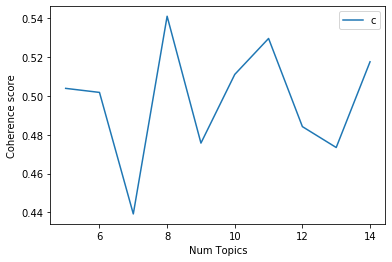

In [32]:
x = range(5, 15, 1)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

Aquí encontramos que el número de topics con mayor coherencia es 8, veamos por qué.

In [33]:
model_list[3].show_topics()

[(0,
  '0.013*"season" + 0.012*"like" + 0.010*"series" + 0.010*"good" + 0.008*"great" + 0.007*"watch" + 0.007*"love" + 0.007*"story" + 0.007*"characters" + 0.006*"movie"'),
 (1,
  '0.014*"use" + 0.013*"product" + 0.011*"good" + 0.010*"great" + 0.010*"like" + 0.010*"car" + 0.007*"works" + 0.006*"easy" + 0.006*"time" + 0.006*"work"'),
 (2,
  '0.022*"trap" + 0.011*"mouse" + 0.009*"traps" + 0.009*"mice" + 0.008*"set" + 0.007*"like" + 0.007*"bait" + 0.006*"house" + 0.006*"work" + 0.006*"use"'),
 (3,
  '0.035*"album" + 0.029*"quot" + 0.018*"song" + 0.015*"like" + 0.015*"songs" + 0.010*"cd" + 0.010*"good" + 0.008*"best" + 0.008*"great" + 0.008*"music"'),
 (4,
  '0.020*"guitar" + 0.013*"great" + 0.013*"sound" + 0.011*"strings" + 0.011*"like" + 0.011*"good" + 0.009*"use" + 0.008*"pedal" + 0.007*"amp" + 0.007*"price"'),
 (5,
  '0.009*"music" + 0.007*"album" + 0.007*"love" + 0.006*"time" + 0.006*"like" + 0.006*"song" + 0.005*"rock" + 0.005*"band" + 0.005*"new" + 0.004*"songs"'),
 (6,
  '0.017*"fe

En general se parece bastante al modelo de 10 topics, sin embargo nos encontramos algunos problemas.

El topic 1 tiene la palabra "car" que podría estar haciendo referencia a Automotive, pero el resto de palabras son muy genéricas.

Los topics 3 y 5 podrían estar hablando de lo mismo.

Aun así, parece un mejor modelo, ya que no nos encontramos ningún topic que no sepamos de qué está hablando.

Respecto al dataset de Patio Lawn and Garden, tenemos 3 topics que parecen distinguirse dentro de este dataset:<br>
· El topic 2 habla de trampas para alimañas.<br>
· El topic 6 habla de mascotas y jardinería.<br>
· El topic 7 habla de posibles usos y herramientas para el patio/jardín.

Veamos ahora si estos topics se corresponden con los topics que asigné originalmente al corpus en base a los dataset de procedencia.